In [ ]:
import numpy as np
import cv2
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, BatchNormalization, UpSampling2D, concatenate, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

In [ ]:
def Encoding(input):
    skip_connections = [] 
    
    # Block 1
    conv1 = Conv2D(filters=64, kernel_size=(3,3), padding='same')(input)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3,3), padding='same')(conv1)
    conv1 = Activation('relu')(conv1)
    skip_connections.append(conv1)  # Store skip connection
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    # Block 2
    conv2 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(pool1)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(conv2)
    conv2 = Activation('relu')(conv2)
    skip_connections.append(conv2)  
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    # Block 3
    conv3 = Conv2D(filters=256, kernel_size=(3,3), padding='same')(pool2)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3,3), padding='same')(conv3)
    conv3 = Activation('relu')(conv3)
    skip_connections.append(conv3)  
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    # Block 4
    conv4 = Conv2D(filters=512, kernel_size=(3,3), padding='same')(pool3)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3,3), padding='same')(conv4)
    conv4 = Activation('relu')(conv4)
    skip_connections.append(conv4)  
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

    # Bottleneck (Middle Block)
    conv5 = Conv2D(filters=1024, kernel_size=(3,3), padding='same')(pool4)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3,3), padding='same')(conv5)
    conv5 = Activation('relu')(conv5)

    return conv5, skip_connections



def decoder(encoded, skip_connections):
    conv6 = UpSampling2D(size=(2,2))(encoded)
    conv6 = concatenate([conv6, skip_connections[-1]])
    conv6 = Conv2D(filters=512, kernel_size=(3,3), padding='same')(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3,3), padding='same')(conv6)
    conv6 = Activation('relu')(conv6)

    conv7 = UpSampling2D(size=(2,2))(conv6)
    conv7 = concatenate([conv7, skip_connections[-2]])
    conv7 = Conv2D(filters=256, kernel_size=(3,3), padding='same')(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3,3), padding='same')(conv7)
    conv7 = Activation('relu')(conv7)

    conv8 = UpSampling2D(size=(2,2))(conv7)
    conv8 = concatenate([conv8, skip_connections[-3]])
    conv8 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(conv8)
    conv8 = Activation('relu')(conv8)

    conv9 = UpSampling2D(size=(2,2))(conv8)
    conv9 = concatenate([conv9, skip_connections[-4]])
    conv9 = Conv2D(filters=64, kernel_size=(3,3), padding='same')(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3,3), padding='same')(conv9)
    conv9 = Activation('relu')(conv9)

    conv10 = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(conv9)

    return conv10
    
def Unet(input_shape=(256,256,3)):
    inputs = Input(input_shape)
    encoded, skip_connections = Encoding(inputs)
    output = decoder(encoded, skip_connections)
    model = Model(inputs, output)
    return model

In [3]:
model = Unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 64, 64, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 64, 64, 256)    │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ activation_5[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 32, 32, 512)    │              0 │ conv2d_6[0][0]         │
├──────────────────────

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Create function for metric evaluation
def dice_coefficients(y_true, y_pred, smooth=100):

    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth)


def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

def jaccard_distance(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    return -iou(y_true_flatten, y_pred_flatten)

In [ ]:
train_origin_dir = "/kaggle/input/hc18-preprocessed-data/split/train_image"
train_mask_dir = "/kaggle/input/hc18-preprocessed-data/split/train_mask"
test_origin_dir = "/kaggle/input/hc18-preprocessed-data/split/test_image"
test_mask_dir = "/kaggle/input/hc18-preprocessed-data/split/test_mask"
valid_origin_dir = "/kaggle/input/hc18-preprocessed-data/split/valid_image"
valid_mask_dir = "/kaggle/input/hc18-preprocessed-data/split/valid_mask"


def load_data(image_dir, mask_dir, image_size=(256, 256)):
    images = []
    masks = []

    image_filenames = sorted(os.listdir(image_dir)) 
    mask_filenames = sorted(os.listdir(mask_dir))

    # Check for dataset mismatch:
    if len(image_filenames) != len(mask_filenames):
        raise ValueError("Mismatch in the number of images and masks.")
    
    # Ensure image and mask filenames match:
    for img_file, mask_file in zip(image_filenames, mask_filenames):
        if img_file.replace('.png', '_Annotation.png') != mask_file: 
            print(f"Image file: {img_file}, Mask file: {mask_file}")  
            raise ValueError("Image and mask filenames do not match.")
    

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and check for None
        img = load_img(img_path, target_size=image_size)
        mask = load_img(mask_path, target_size=image_size, color_mode='grayscale')
        
        if img is None:
            print(f"Warning: Could not load image at {img_path}. Skipping.")
            continue
        if mask is None:
            print(f"Warning: Could not load mask at {mask_path}. Skipping.")
            continue
            
        img = img_to_array(img) / 255.0
        mask = img_to_array(mask) / 255.0
        
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load full dataset into memory
X_train, Y_train = load_data(train_origin_dir, train_mask_dir)
X_valid, Y_valid = load_data(valid_origin_dir, valid_mask_dir)


# Train
model = Unet(input_shape=(256,256,3))

# Define hyperparameters
EPOCHS = 50
BATCH_SIZE = 16
learning_rate = 1e-4
smooth = 100
decay_rate = learning_rate / EPOCHS

# Define optimizer
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])



# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=5,           
    restore_best_weights=True,  
    verbose=1
)

# Define model checkpoint callback to save the best model
checkpoint = ModelCheckpoint(
    'unet_model.keras',  
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model with early stopping and checkpointing
hist = model.fit(
    X_train, Y_train,
    validation_data=(X_valid, Y_valid),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, checkpoint] 
)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - binary_accuracy: 0.2971 - dice_coefficients: 0.3771 - iou: 0.2357 - loss: -0.3771
Epoch 1: val_loss improved from inf to -0.52787, saving model to unet_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 73s 842ms/step - binary_accuracy: 0.3018 - dice_coefficients: 0.3792 - iou: 0.2376 - loss: -0.3792 - val_binary_accuracy: 0.7998 - val_dice_coefficients: 0.5279 - val_iou: 0.3622 - val_loss: -0.5279
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - binary_accuracy: 0.8886 - dice_coefficients: 0.7838 - iou: 0.6469 - loss: -0.7838
Epoch 2: val_loss improved from -0.52787 to -0.58944, saving model to unet_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 445ms/step - binary_accuracy: 0.8890 - dice_coefficients: 0.7845 - iou: 0.6479 - loss: -0.7845 - val_binary_accuracy: 0.8606 - val_dice_coefficients: 0.5894 - val_iou: 0.4220 - val_loss: -0.5894
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - binary_accuracy: 0.9275 - dice_coefficients: 0.8469 -

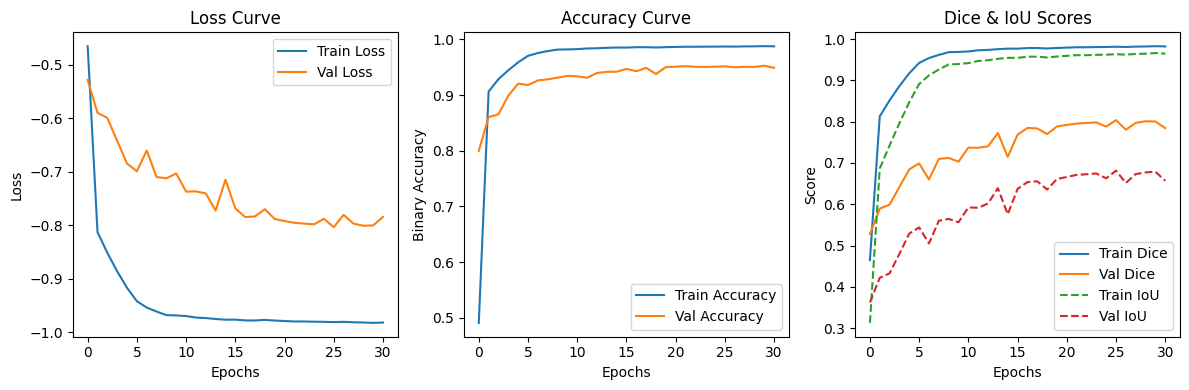

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['binary_accuracy']
val_acc = hist.history['val_binary_accuracy']
train_dice = hist.history['dice_coefficients']
val_dice = hist.history['val_dice_coefficients']
train_iou = hist.history['iou']
val_iou = hist.history['val_iou']

epochs_range = range(len(train_loss))  


plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.title('Accuracy Curve')


plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_dice, label='Train Dice')
plt.plot(epochs_range, val_dice, label='Val Dice')
plt.plot(epochs_range, train_iou, '--', label='Train IoU')
plt.plot(epochs_range, val_iou, '--', label='Val IoU')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Dice & IoU Scores')

plt.tight_layout()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step 


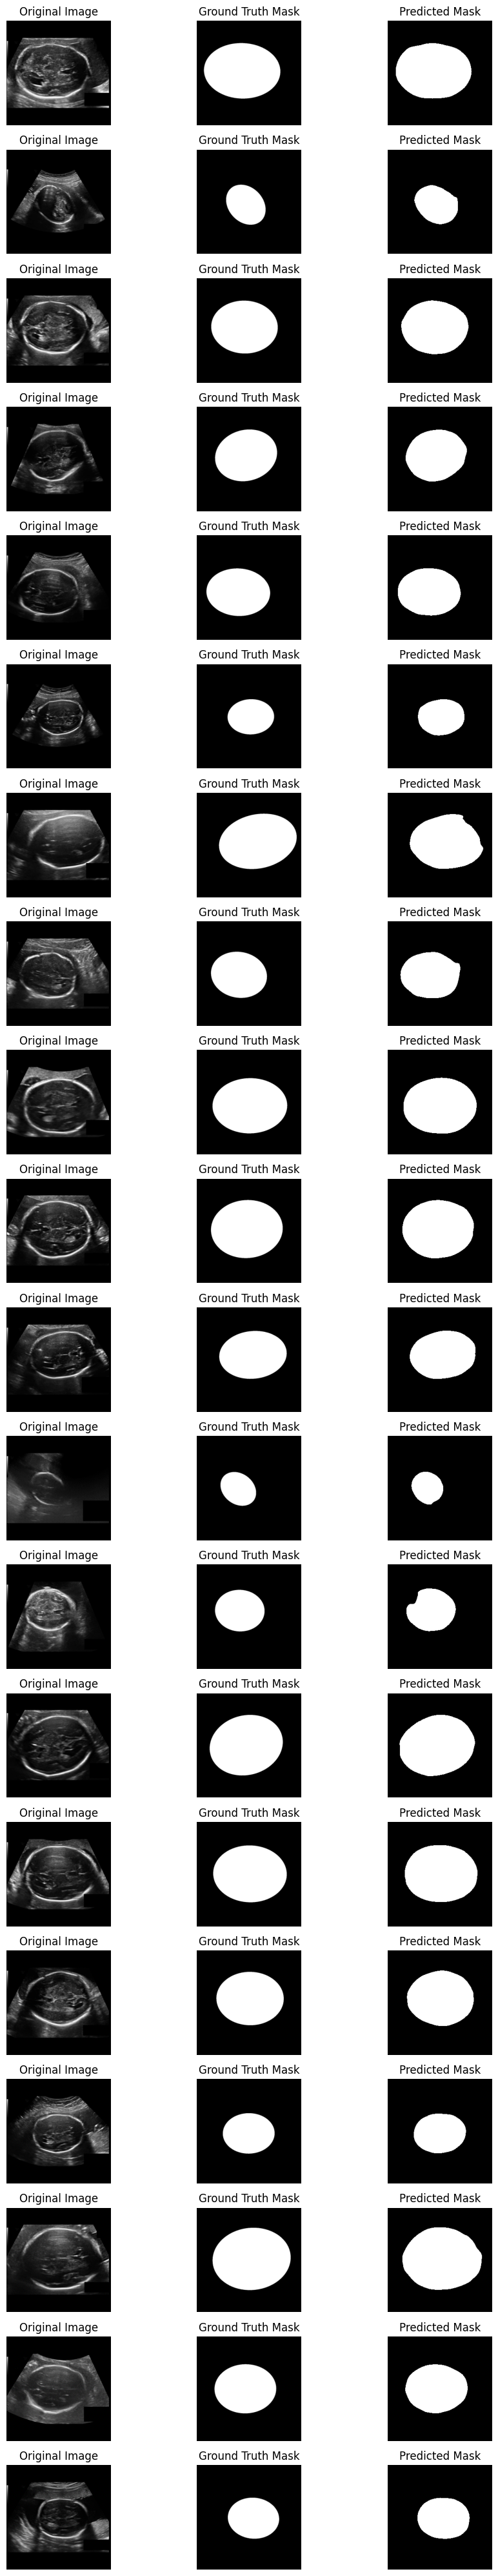

In [7]:
# Load test data
X_test, y_test = load_data(test_origin_dir, test_mask_dir)

# Make Predictions
y_pred = model.predict(X_test)

# Convert predictions to binary masks (Thresholding)
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)

# Plot first 20 images
fig, axes = plt.subplots(20, 3, figsize = (10, 40))

for i in range(20):
    # Original Image
    axes[i, 0].imshow(X_test[i])
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    # Ground Truth Mask
    axes[i, 1].imshow(y_test[i].squeeze(), cmap="gray")
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis("off")

    # Predicted Mask
    axes[i, 2].imshow(y_pred_thresholded[i].squeeze(), cmap="gray")
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

# Regression Task: From hc-18-regression.ipynb file

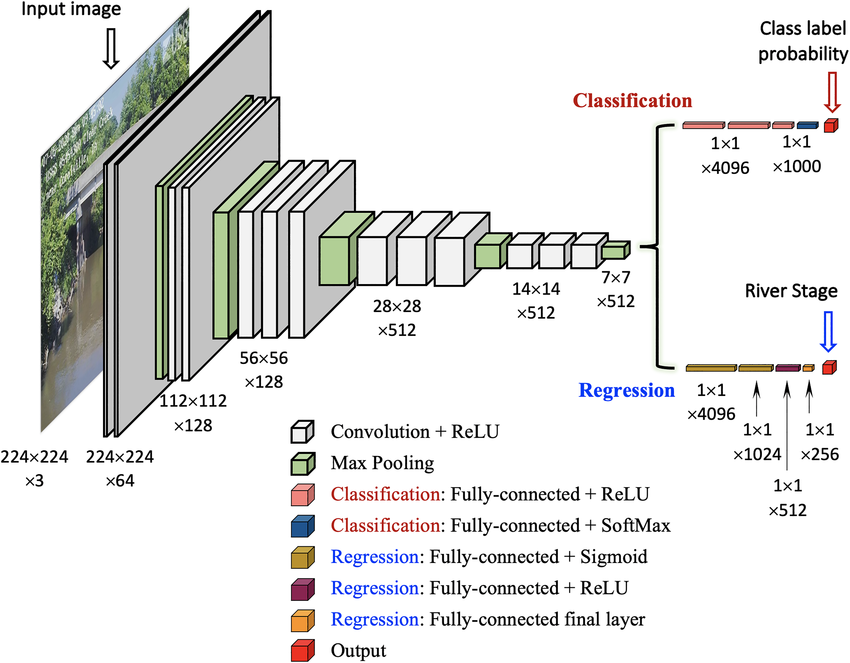
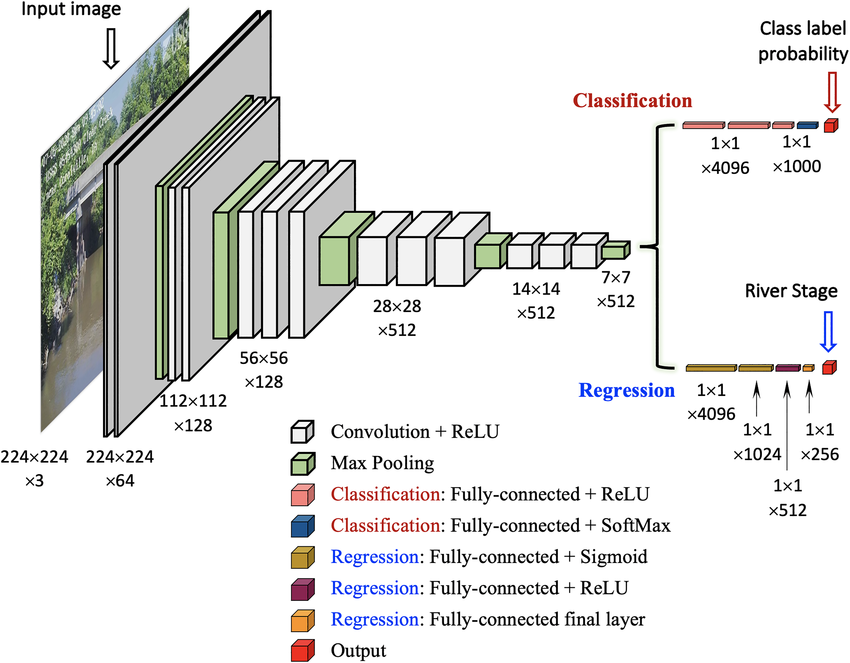